In [ ]:
import os
import kaggle
import torchvision
from pathlib import Path

# Download dataset
dataset_name = "omkarmanohardalvi/lungs-disease-dataset-4-types"
download_path = "./lung_disease_data"

# Create directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# Verify the download
data_dir = Path(download_path)
print("\nDataset structure:")
for item in data_dir.glob("*"):
    if item.is_dir():
        print(f"{item.name}/")
        files = len(list(item.glob("*")))
        print(f"  - Contains {files} files")

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset structure:
Lung Disease Dataset/
  - Contains 3 files


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path

# Define the class names (in the order we found them)
CLASS_NAMES = [
    'Corona Virus Disease',
    'Viral Pneumonia',
    'Tuberculosis',
    'Bacterial Pneumonia',
    'Normal'
]

# Create class to index mapping
class_to_idx = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}

class LungDiseaseDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Path to the lung disease dataset
            split (str): 'train', 'val', or 'test'
            transform: Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir) / "Lung Disease Dataset" / split
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collect all image paths and labels
        for class_name in CLASS_NAMES:
            class_path = self.root_dir / class_name
            for img_path in class_path.glob('*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    self.image_paths.append(img_path)
                    self.labels.append(class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Let's verify the dataset loading
dataset_path = "./lung_disease_data"
splits = ['train', 'val', 'test']

print("Dataset statistics:")
for split in splits:
    dataset = LungDiseaseDataset(dataset_path, split=split)
    print(f"\n{split.capitalize()} set:")
    print(f"Total images: {len(dataset)}")

    # Count images per class
    class_counts = {}
    for label in dataset.labels:
        class_name = CLASS_NAMES[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")

Dataset statistics:

Train set:
Total images: 6054
  Corona Virus Disease: 1218 images
  Viral Pneumonia: 1204 images
  Tuberculosis: 1220 images
  Bacterial Pneumonia: 1205 images
  Normal: 1207 images

Val set:
Total images: 2016
  Corona Virus Disease: 406 images
  Viral Pneumonia: 401 images
  Tuberculosis: 406 images
  Bacterial Pneumonia: 401 images
  Normal: 402 images

Test set:
Total images: 2025
  Corona Virus Disease: 407 images
  Viral Pneumonia: 403 images
  Tuberculosis: 408 images
  Bacterial Pneumonia: 403 images
  Normal: 404 images


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
INITIAL_LR = 0.001

# Transforms remain the same
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LungDiseaseDataset(
    root_dir="./lung_disease_data",
    split='train',
    transform=train_transform
)

val_dataset = LungDiseaseDataset(
    root_dir="./lung_disease_data",
    split='val',
    transform=val_transform
)

test_dataset = LungDiseaseDataset(
    root_dir="./lung_disease_data",
    split='test',
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [ ]:
# Creating model based from pretrained mobileNet
model = models.mobilenet_v3_small(pretrained=True)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, len(CLASS_NAMES))
model = model.to(device)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=INITIAL_LR,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Learning rate scheduler (removed verbose parameter)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5
)

# Create a function to monitor learning rate
def get_lr():
    return optimizer.param_groups[0]['lr']

# Print setup summary
print("=== Model Setup ===")
print(f"Device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Initial learning rate: {get_lr()}")
print("\n=== Dataset Summary ===")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


=== Model Setup ===
Device: cuda
Number of parameters: 1,522,981
Initial learning rate: 0.001

=== Dataset Summary ===
Training batches: 190
Validation batches: 63
Test batches: 64


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Verify a batch
for images, labels in train_loader:
    print("\n=== Batch Verification ===")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


=== Batch Verification ===
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [38]:
import time
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import os

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).float().mean()

        losses.update(loss.item(), images.size(0))
        accuracies.update(acc.item(), images.size(0))

        pbar.set_postfix({
            'loss': f'{losses.avg:.4f}',
            'acc': f'{accuracies.avg:.4f}',
            'lr': f'{get_lr():.6f}'
        })

    return losses.avg, accuracies.avg

def validate(model, val_loader, criterion, device):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            losses.update(loss.item(), images.size(0))
            accuracies.update(acc.item(), images.size(0))

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return losses.avg, accuracies.avg, f1

# Create checkpoint directory
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, history, val_loss, val_acc, val_f1, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_f1': val_f1
    }

    # Save periodic checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)

    # Save best model separately
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save(checkpoint, best_model_path)

    # Keep only the last 3 checkpoints to save space
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_')])
    for old_checkpoint in checkpoints[:-3]:
        os.remove(os.path.join(checkpoint_dir, old_checkpoint))

def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_loss = checkpoint['val_loss']
        print(f"Resuming from epoch {start_epoch}")
        return start_epoch, history, best_val_loss
    return 0, {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'lr': []
    }, float('inf')

# Training configuration
num_epochs = 7
patience = 5  # Early stopping patience
checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')

# Load checkpoint if exists
start_epoch, history, best_val_loss = load_checkpoint(
    checkpoint_path, model, optimizer, scheduler
)
patience_counter = 0

In [44]:
print("Starting training...")

for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = get_lr()

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Save checkpoint
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    save_checkpoint(
        epoch, model, optimizer, history,
        val_loss, val_acc, val_f1, is_best
    )

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

print("Training completed!")

Starting training...

Epoch 1/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


Train Loss: 0.4303 | Train Acc: 0.9841
Val Loss: 0.5769 | Val Acc: 0.9162 | Val F1: 0.9159
Learning Rate: 0.000001

Epoch 2/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


Train Loss: 0.4324 | Train Acc: 0.9833
Val Loss: 0.5773 | Val Acc: 0.9152 | Val F1: 0.9149
Learning Rate: 0.000001

Epoch 3/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


Train Loss: 0.4308 | Train Acc: 0.9838
Val Loss: 0.5772 | Val Acc: 0.9162 | Val F1: 0.9159
Learning Rate: 0.000001

Epoch 4/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Train Loss: 0.4295 | Train Acc: 0.9853
Val Loss: 0.5772 | Val Acc: 0.9157 | Val F1: 0.9154
Learning Rate: 0.000001

Epoch 5/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]


Train Loss: 0.4328 | Train Acc: 0.9822
Val Loss: 0.5776 | Val Acc: 0.9152 | Val F1: 0.9149
Learning Rate: 0.000001

Epoch 6/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


Train Loss: 0.4299 | Train Acc: 0.9860
Val Loss: 0.5773 | Val Acc: 0.9167 | Val F1: 0.9164
Learning Rate: 0.000001

Epoch 7/7


Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]

Train Loss: 0.4307 | Train Acc: 0.9845
Val Loss: 0.5777 | Val Acc: 0.9157 | Val F1: 0.9154
Learning Rate: 0.000000
Training completed!


Plotting training history...


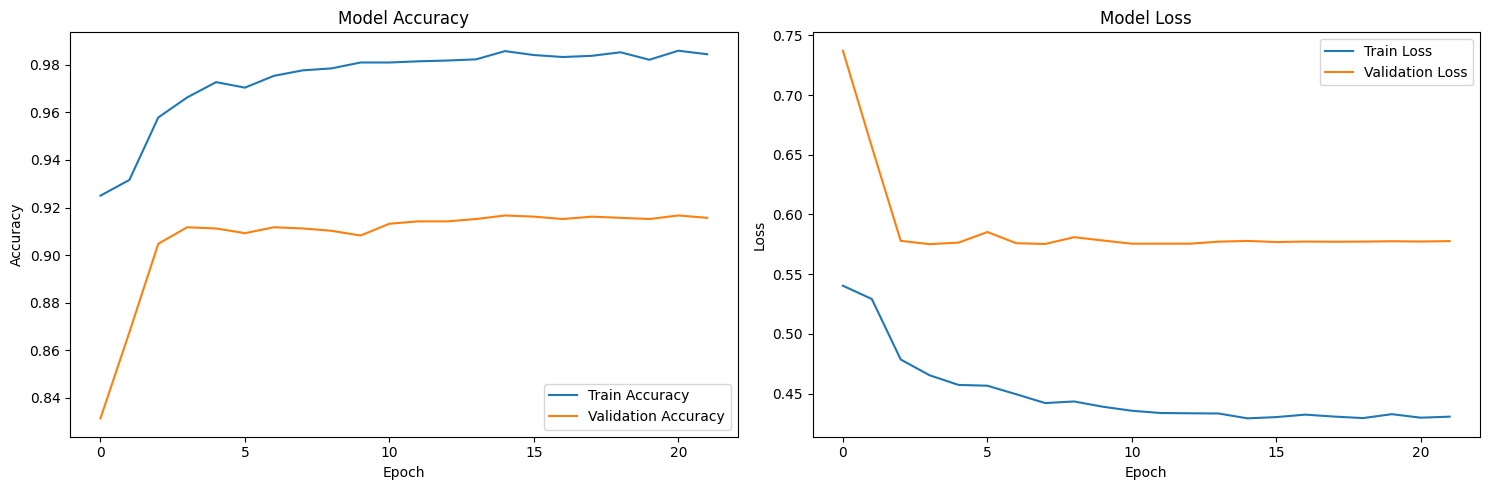

<ipython-input-45-6e166cdef492>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)



Evaluating on test set...


Evaluating: 100%|██████████| 64/64 [00:29<00:00,  2.18it/s]



Classification Report:
                      precision    recall  f1-score   support

Corona Virus Disease       0.99      0.99      0.99       407
     Viral Pneumonia       0.80      0.78      0.79       403
        Tuberculosis       0.99      1.00      0.99       408
 Bacterial Pneumonia       0.82      0.82      0.82       403
              Normal       0.95      0.97      0.96       404

            accuracy                           0.91      2025
           macro avg       0.91      0.91      0.91      2025
        weighted avg       0.91      0.91      0.91      2025


Generating confusion matrix...


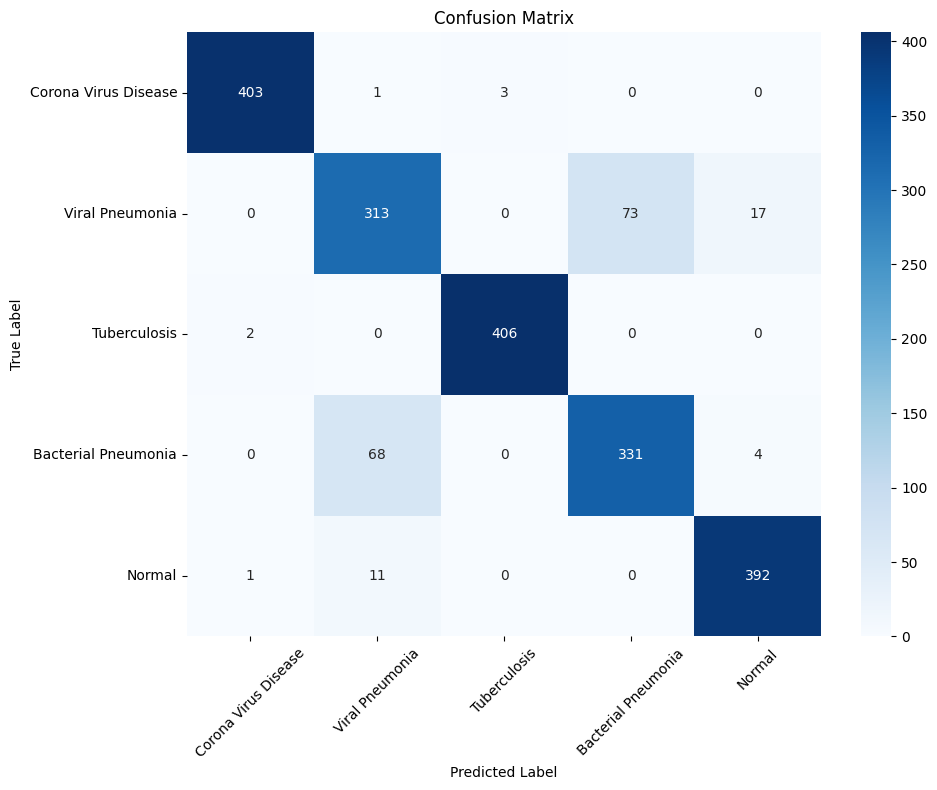

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_history(history):
    # Set up the figure
    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_predictions), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print("Plotting training history...")
plot_training_history(history)


best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

print("\nEvaluating on test set...")
predictions, labels = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=CLASS_NAMES))

# Plot confusion matrix
print("\nGenerating confusion matrix...")
plot_confusion_matrix(labels, predictions, CLASS_NAMES)

# Save results
results = {
    'predictions': predictions,
    'true_labels': labels,
    'history': history,
    'class_names': CLASS_NAMES
}
torch.save(results, os.path.join(checkpoint_dir, 'evaluation_results.pth'))

In [46]:
model_save_path = 'lung-disease-predictor.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to lung-disease-predictor.pth


In [51]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt

class LungDiseasePredictor:
    def __init__(self, model_path, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')


        self.model = models.mobilenet_v3_small(pretrained=False)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, len(CLASS_NAMES))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()


        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Get prediction
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_prob, pred_class = torch.max(probabilities, 1)

        return {
            'class': CLASS_NAMES[pred_class.item()],
            'probability': pred_prob.item(),
            'all_probabilities': {
                class_name: prob.item()
                for class_name, prob in zip(CLASS_NAMES, probabilities[0])
            }
        }

    def predict_batch(self, image_paths):
        results = []
        for path in image_paths:
            results.append(self.predict(path))
        return results

def visualize_prediction(image_path, prediction):

    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 5))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Plot probabilities
    plt.subplot(1, 2, 2)
    probs = prediction['all_probabilities']
    names = list(probs.keys())
    values = list(probs.values())

    plt.barh(names, values)
    plt.title('Prediction Probabilities')
    plt.xlabel('Probability')

    plt.tight_layout()
    plt.show()

<ipython-input-51-6bf5a6d8db98>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))



Prediction Results:
Predicted Class: Bacterial Pneumonia
Confidence: 92.88%

All Class Probabilities:
Corona Virus Disease: 1.71%
Viral Pneumonia: 0.51%
Tuberculosis: 2.50%
Bacterial Pneumonia: 92.88%
Normal: 2.40%


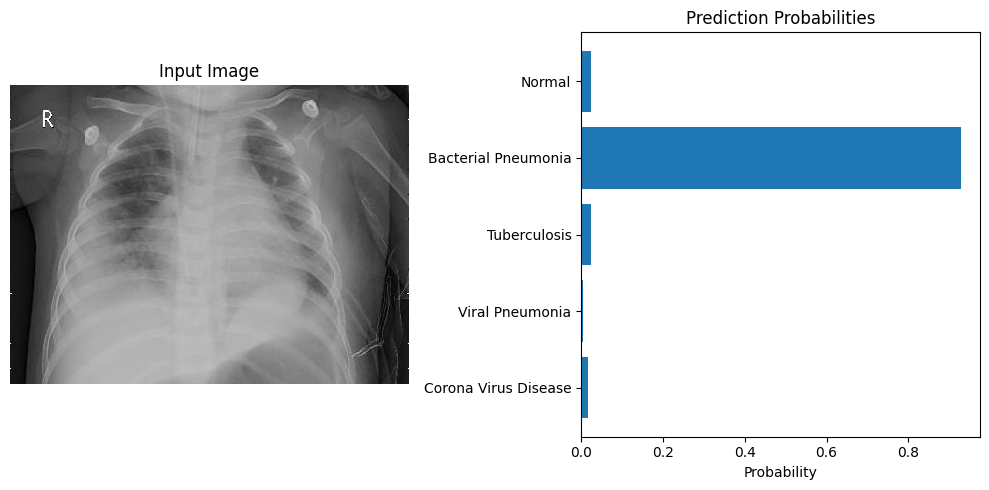

In [52]:
# Create predictor
predictor = LungDiseasePredictor(
    model_path='lung-disease-predictor.pth'
)

# Test on a single image
test_image_path = "/content/lung_disease_data/Lung Disease Dataset/train/Bacterial Pneumonia/1.jpeg"
if os.path.exists(test_image_path):
    prediction = predictor.predict(test_image_path)
    print("\nPrediction Results:")
    print(f"Predicted Class: {prediction['class']}")
    print(f"Confidence: {prediction['probability']:.2%}")

    print("\nAll Class Probabilities:")
    for class_name, prob in prediction['all_probabilities'].items():
        print(f"{class_name}: {prob:.2%}")

    visualize_prediction(test_image_path, prediction)